<a href="https://colab.research.google.com/github/Arun152k/Masked-Deep-Face-Recognition-using-ArcFace-and-Ensemble-Learning/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras import backend as K
from keras.layers import Layer
from keras import regularizers

import tensorflow as tf
from tensorflow.python import keras
from keras.models import Sequential

from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D,Input

from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.layers. normalization import BatchNormalization

from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from google.colab import drive
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Aug  6 12:56:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
class ArcFace(Layer):
    def __init__(self, n_classes=10, s=10.0, m=0.30, regularizer=None, **kwargs):
        super(ArcFace, self).__init__(**kwargs)
        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.regularizer = regularizers.get(regularizer)

    def build(self, input_shape):
        super(ArcFace, self).build(input_shape[0])
        self.W = self.add_weight(name='W',
                                shape=(input_shape[0][-1], self.n_classes),
                                initializer='glorot_uniform',
                                trainable=True,
                                regularizer=self.regularizer)

    def call(self, inputs):
        x, y = inputs
        c = K.shape(x)[-1]
        x = tf.nn.l2_normalize(x, axis=1)
        W = tf.nn.l2_normalize(self.W, axis=0)
        logits = x @ W
        theta = tf.acos(K.clip(logits, -1.0 + K.epsilon(), 1.0 - K.epsilon()))
        target_logits = tf.cos(theta + self.m)
        # sin = tf.sqrt(1 - logits**2)
        # cos_m = tf.cos(logits)
        # sin_m = tf.sin(logits)
        # target_logits = logits * cos_m - sin * sin_m
        logits = logits * (1 - y) + target_logits * y
        logits *= self.s
        out = tf.nn.softmax(logits)
        return out

    def compute_output_shape(self, input_shape):
        return (None, self.n_classes)

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='acc'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [ ]:
from keras.applications.densenet import DenseNet201
from keras.optimizers import SGD
rows=224
cols=224

num_classes = 75
input_shape = (224,224,3)
batch_size=64
dense_base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)
x = dense_base_model.output
y = Input(shape=(num_classes, ))

x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(512, use_bias=False)(x)
x = BatchNormalization()(x)
dense_predictions = ArcFace(num_classes)([x, y])

dense_model = Model(inputs=[dense_base_model.input,y], outputs=dense_predictions)

for layer in dense_base_model.layers:
    layer.trainable = False

dense_model.summary()
opt = SGD(lr=0.1, momentum=0.9, decay=5e-4, nesterov=True)
dense_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy',METRICS])

74850304/74836368 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from google.colab import drive
import pandas as pd
import pathlib
batch_size=64
drive.mount('/content/drive')
train_dir="/content/drive/My Drive/Mixed/train"
val_dir=r"/content/drive/My Drive/Mixed/val"
test_dir=r"/content/drive/My Drive/Mixed/test"
class train_Generator_xandy(object):
    def __init__(self):
        datagen = ImageDataGenerator(rescale=1. / 255.)
        train_generator = datagen.flow_from_directory(
            train_dir,
            target_size=(rows, cols),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False)

        self.gene = train_generator

    def __iter__(self):
        return self

    def __next__(self):
        X, Y = self.gene.next()
        return [X, Y], Y

class val_Generator_xandy(object):
    def __init__(self):
        validation_datagen = ImageDataGenerator(rescale=1. / 255.)

        validation_generator = validation_datagen.flow_from_directory(
            val_dir,
            target_size=(rows, cols),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False,
        )

        self.gene = validation_generator

    def __iter__(self):
        return self

    def __next__(self):
        X, Y = self.gene.next()
       
        return [X, Y], Y

class test_Generator_xandy(object):
    def __init__(self):
        test_datagen = ImageDataGenerator(rescale=1.0 / 255.)

        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(rows, cols),
            batch_size=1,
            class_mode='categorical',
            shuffle=False,
        )

        self.gene = test_generator
        self.classes = test_generator.classes

    def __iter__(self):
        return self

    def __next__(self):
        X, Y = self.gene.next()
        return [X, Y], Y

train_generator = train_Generator_xandy()
validation_generator = val_Generator_xandy()

Mounted at /content/drive
Found 15000 images belonging to 75 classes.
Found 3750 images belonging to 75 classes.


In [ ]:
callbacks_TL = [            
             keras.callbacks.ModelCheckpoint("best_dense.h5",
                                             monitor='val_accuracy',
                                             save_weights_only=True,
                                             save_best_only=True)]
history = dense_model.fit(train_generator,
                    steps_per_epoch=(15000 // batch_size),
                    epochs=70,
                    validation_data=validation_generator,
                    validation_steps=(3750 // batch_size),
                    callbacks=callbacks_TL
                   )

Epoch 1/70
234/234 [==============================] - 5372s 23s/step - loss: 7.2939 - accuracy: 0.0433 - tp: 54.6793 - fp: 187.3376 - tn: 281594.5045 - fn: 3753.1845 - acc: 0.0840 - precision: 0.2867 - recall: 0.0336 - auc: 0.1778 - val_loss: 7.2781 - val_accuracy: 0.0046 - val_tp: 60.0000 - val_fp: 372.0000 - val_tn: 1247564.1250 - val_fn: 16804.0000 - val_acc: 0.0124 - val_precision: 0.1389 - val_recall: 0.0036 - val_auc: 0.1703
Epoch 2/70
234/234 [==============================] - 48s 202ms/step - loss: 6.8963 - accuracy: 0.0062 - tp: 60.0000 - fp: 374.8709 - tn: 1661361.2197 - fn: 22395.8638 - acc: 0.0107 - precision: 0.1380 - recall: 0.0027 - auc: 0.1886 - val_loss: 7.2483 - val_accuracy: 0.0081 - val_tp: 60.0000 - val_fp: 376.0000 - val_tn: 2627512.7500 - val_fn: 35452.0000 - val_acc: 0.0077 - val_precision: 0.1376 - val_recall: 0.0017 - val_auc: 0.2369
Epoch 3/70
234/234 [==============================] - 47s 203ms/step - loss: 6.8039 - accuracy: 0.0126 - tp: 61.4792 - fp: 376.0

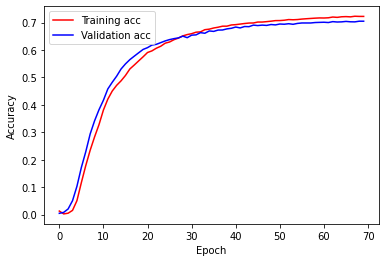

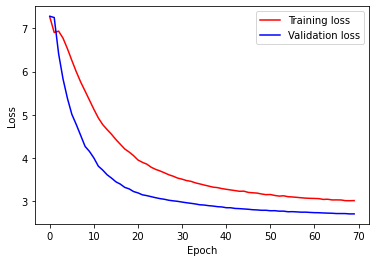

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
dense_model.save_weights('Densenet.h5')

In [ ]:
from google.colab import files
files.download("/content/Densenet.h5") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Loading the DenseNet model  
dense_model.get_weights()

[array([[[[ 1.67561732e-02, -8.00370518e-03,  1.64543441e-03, ...,
            1.26166886e-03,  3.58251086e-03,  5.00720441e-02],
          [ 3.52577120e-03, -3.64364404e-03, -2.38160999e-03, ...,
            7.10624317e-03, -4.59333062e-02,  4.04555760e-02],
          [-1.07177328e-02,  1.16608981e-02, -1.62183940e-02, ...,
           -1.25643087e-03,  4.74995635e-02, -5.65207303e-02]],
 
         [[ 2.93081421e-02, -4.43431875e-03, -5.66792954e-03, ...,
           -2.81210039e-02, -1.22120537e-01,  4.98253154e-03],
          [ 2.05341447e-02, -1.57353729e-02, -1.68054383e-02, ...,
           -3.82820331e-02, -1.72879219e-01, -2.28659809e-02],
          [ 3.79234087e-03,  1.59432145e-03, -7.88045395e-03, ...,
           -1.53475470e-04, -7.57230818e-02,  1.12526519e-02]],
 
         [[ 7.06844777e-03,  7.31188993e-05, -8.05904791e-02, ...,
            1.21061690e-02, -1.02497220e-01,  1.75693817e-02],
          [-4.92295530e-03, -8.76990799e-03, -9.14027095e-02, ...,
            4.158

In [ ]:
test_generator = test_Generator_xandy()

Found 3750 images belonging to 75 classes.


In [ ]:
predict = dense_model.predict(test_generator,steps = 3750)
print(predict)
import numpy as np
predicted_class_indices=np.argmax(predict,axis=1)
print(predicted_class_indices)

[[1.3298115e-06 4.4870362e-02 1.0884366e-02 ... 1.6209427e-02
  2.0122845e-02 2.6279690e-02]
 [7.1681620e-07 3.8413737e-02 1.4925544e-02 ... 3.4024693e-02
  1.9652691e-02 1.5294731e-02]
 [6.6621840e-07 3.3449329e-02 1.5975239e-02 ... 3.7299979e-02
  2.0608382e-02 1.7731899e-02]
 ...
 [3.5877284e-02 1.5821094e-03 3.9933637e-02 ... 3.5462659e-03
  2.4039105e-03 1.5716197e-01]
 [1.9515002e-02 9.9445751e-04 5.0865158e-02 ... 7.5509502e-03
  2.5078077e-03 1.6171803e-01]
 [8.6165695e-03 1.7397369e-03 1.8032448e-02 ... 3.0702045e-03
  1.3462035e-03 5.0937301e-01]]
[ 1 64 64 ... 74 74 74]


In [ ]:
test_datagen1 = ImageDataGenerator(rescale=1./255)

test_generator1 = test_datagen1.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator1.filenames
nb_samples = len(filenames)
test_generator1.reset()

Found 3750 images belonging to 75 classes.


In [ ]:
labels = (test_generator1.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
filenames=test_generator1.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [ ]:
count=0
wrong_prediction=[]
true=[[]]
for i in range(len(results)):    
    s=results["Filename"][i]
    #print(s)
    v=s[0:s.find("/")]
    if (v) == results["Predictions"][i]:
        count+=1
        true.append(v)
    else :
        wrong_data=[s,v,results["Predictions"][i]]
        wrong_prediction.append(wrong_data)
        
    print(v,results["Predictions"][i])

acc=((count/len(results))*100)
print("The accuracy is :",acc," %")

Aarav Abhaya
Aarav Sushanth
Aarav Sushanth
Aarav Sushanth
Aarav Aarav
Aarav Sushanth
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav AravindRam
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav SharmilaMaam
Aarav Chandru
Aarav Lakshman1
Aarav Anish
Aarav Aarav
Aarav AravindRam
Aarav AravindRam
Aarav Sushanth
Aarav Sushanth
Aarav Sushanth
Aarav Sushanth
Aarav Adhu
Aarav Aarav
Aarav Anish
Aarav Lakshman1
Aarav Anish
Aarav Anish
Aarav SharmilaMaam
Aarav Aarav
Aarav Aarav
Aarav SharmilaMaam
Aarav Aarav
Abhaya Abhaya
Abhaya Abhaya
Abhaya Abhaya
Abhaya Abhaya
Abhaya Koushika P
Abhaya Abhaya
Abhaya Abhaya
Abhaya Abhaya
Abhaya Siddhu
Abhaya Abhaya
Abhaya Vikas
Abhaya Koushika P
Abhaya Vikas
Abhaya Abhaya
Abhaya Abhaya
Abhaya Abhaya
Abhaya Abhaya
Abhaya Siddhu
Abhaya Abhaya
Abhaya Abhaya
Abhaya Abhaya
Abhaya Abhaya
Abhaya Abhaya
Ab

In [ ]:
#Loading the best DenseNet model
dense_model.load_weights("best_dense.h5")

In [ ]:
from google.colab import files
files.download("/content/best_dense.h5") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dense_model.get_weights()

[array([[[[ 1.67561732e-02, -8.00370518e-03,  1.64543441e-03, ...,
            1.26166886e-03,  3.58251086e-03,  5.00720441e-02],
          [ 3.52577120e-03, -3.64364404e-03, -2.38160999e-03, ...,
            7.10624317e-03, -4.59333062e-02,  4.04555760e-02],
          [-1.07177328e-02,  1.16608981e-02, -1.62183940e-02, ...,
           -1.25643087e-03,  4.74995635e-02, -5.65207303e-02]],
 
         [[ 2.93081421e-02, -4.43431875e-03, -5.66792954e-03, ...,
           -2.81210039e-02, -1.22120537e-01,  4.98253154e-03],
          [ 2.05341447e-02, -1.57353729e-02, -1.68054383e-02, ...,
           -3.82820331e-02, -1.72879219e-01, -2.28659809e-02],
          [ 3.79234087e-03,  1.59432145e-03, -7.88045395e-03, ...,
           -1.53475470e-04, -7.57230818e-02,  1.12526519e-02]],
 
         [[ 7.06844777e-03,  7.31188993e-05, -8.05904791e-02, ...,
            1.21061690e-02, -1.02497220e-01,  1.75693817e-02],
          [-4.92295530e-03, -8.76990799e-03, -9.14027095e-02, ...,
            4.158

In [ ]:
test_generator2 = test_Generator_xandy()

Found 3750 images belonging to 75 classes.


In [ ]:
predict = dense_model.predict(test_generator2,steps = 3750)
print(predict)
import numpy as np
predicted_class_indices=np.argmax(predict,axis=1)
print(predicted_class_indices)

[[1.3366558e-06 4.3769158e-02 1.0827833e-02 ... 1.5941547e-02
  2.0473748e-02 2.6749276e-02]
 [7.2211765e-07 3.7641056e-02 1.4577407e-02 ... 3.4101393e-02
  1.9691953e-02 1.5458964e-02]
 [6.7196879e-07 3.2888170e-02 1.5553801e-02 ... 3.7355103e-02
  2.0662315e-02 1.7834479e-02]
 ...
 [3.2555867e-02 1.7235867e-03 4.0081684e-02 ... 2.9212481e-03
  2.5373783e-03 1.5140134e-01]
 [1.8205585e-02 1.0203002e-03 5.2235212e-02 ... 6.1819591e-03
  2.5498543e-03 1.7214465e-01]
 [7.3988242e-03 1.7238302e-03 1.6743185e-02 ... 2.5002472e-03
  1.1921701e-03 5.4722512e-01]]
[ 1 64 64 ... 74 74 74]


In [ ]:
test_datagen3 = ImageDataGenerator(rescale=1./255)

test_generator3 = test_datagen3.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator3.filenames
nb_samples = len(filenames)
test_generator3.reset()

Found 3750 images belonging to 75 classes.


In [ ]:
labels = (test_generator1.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
filenames=test_generator1.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [ ]:
count=0
wrong_prediction=[]
true=[[]]
for i in range(len(results)):    
    s=results["Filename"][i]
    #print(s)
    v=s[0:s.find("/")]
    if (v) == results["Predictions"][i]:
        count+=1
        true.append(v)
    else :
        wrong_data=[s,v,results["Predictions"][i]]
        wrong_prediction.append(wrong_data)
    print(v,results["Predictions"][i])

acc=((count/len(results))*100)
print(count)
print("The accuracy is :",acc," %")

Aarav Abhaya
Aarav Sushanth
Aarav Sushanth
Aarav Sushanth
Aarav Aarav
Aarav Sushanth
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav AravindRam
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav Aarav
Aarav SharmilaMaam
Aarav Chandru
Aarav Anish
Aarav Anish
Aarav Aarav
Aarav Aarav
Aarav AravindRam
Aarav Sushanth
Aarav Sushanth
Aarav Sushanth
Aarav Sushanth
Aarav Adhu
Aarav Aarav
Aarav Anish
Aarav Lakshman1
Aarav Anish
Aarav Anish
Aarav SharmilaMaam
Aarav Aarav
Aarav Aarav
Aarav SharmilaMaam
Aarav Aarav
Abhaya Abhaya
Abhaya Abhaya
Abhaya Abhaya
Abhaya Abhaya
Abhaya Koushika P
Abhaya Abhaya
Abhaya Abhaya
Abhaya Abhaya
Abhaya Siddhu
Abhaya Abhaya
Abhaya Vikas
Abhaya Koushika P
Abhaya Vikas
Abhaya Abhaya
Abhaya Abhaya
Abhaya Abhaya
Abhaya Abhaya
Abhaya Siddhu
Abhaya Abhaya
Abhaya Abhaya
Abhaya Abhaya
Abhaya Abhaya
Abhaya Abhaya
Abhaya Abha

In [ ]:
files.download("/content/best_dense.h5") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>